# Analyze the Treasure Archive

In [1]:
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import Layout
import webbrowser    # for opening web pages
import networkx as nx
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output
import pickle

In [2]:
with open('pickle/treasury.p', 'rb') as f: 
    G = pickle.load(f)

# Compute some node centrality measures
We may compute a variety of characteristics of each node in our graph. There are different ways to conceptualize the centrality  of a node in a graph. The number of connections of a node to other nodes in the graph contributes to its *degree centrality*. *In degree centrality* refers to the number of incoming connections (where the node is target), whereas *out degree centrality* relates to the number of outgoing connections (where the node source). *Betweenness centrality* is based on the number of shortest paths between any two nodes in the graph that go through this node. *Eigenvector centrality* is a measure that takes into account the centrality of the nodes that the node under consideration connects to. A node that connects to many low-ranking nodes will receive a low eigenvector centrality score. A node that connects to a few well-connected nodes will receive a high eigenvector centrality score.

*Hub* and *authority*, finally, are interrelated measures that were originally developed for ranking web pages. A node with high hub value points towards multiple nodes with high authority value. A node with high authority value has incoming connections from multiple nodes with high hub  value. Hub and authority are thus defined by each other and the process of computing hub and authority values is an iterative one. If `nx.hits()` raises a "PowerIterationFailedConvergence" error, you may increase the maximum number of iterations. The default value is `max_iter=100`; use, for instance `hub, authority = nx.hits(G, max_iter = 1000)`.

Each of these computations results in a dictionary in which the nodes are keys.

In [3]:
eigenvector = nx.eigenvector_centrality(G)
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub, authority = nx.hits(G, max_iter=600)

Print the first 5 highest scoring nodes for each of the centrality measure. In each of these measures we see more or less the same names popping up, but not in the same order. 

In [4]:
centrality = [eigenvector, degree_centrality, in_degree_centrality, out_degree_centrality, closeness_centrality, betweenness_centrality, hub, authority]
centrality_labels = ["eigenvector", "degree centrality", "in degree centrality",
                     "out degree centrality", "closeness centrality",
                     "betweenness centrality", "hub", "authority"]
for idx, m in enumerate(centrality):
    s = sorted(m, key=m.get, reverse=True)[:5]
    print(f"{centrality_labels[idx]}: {s}")

eigenvector: ['lugal[king]N', 'Ludiŋirak[0]PN', 'Lugalkugzu[0]PN', 'Šušulgir[0]PN', 'AradNannak[0]PN']
degree centrality: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'lugal[king]N', 'Dayyanummišar[0]PN', 'AradNannak[0]PN']
in degree centrality: ['Ludiŋirak[0]PN', 'Lugalkugzu[0]PN', 'lugal[king]N', 'PuzurErra[0]PN', 'Lunanna[0]PN']
out degree centrality: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'Dayyanummišar[0]PN', 'AradNannak[0]PN', 'lugal[king]N']
closeness centrality: ['lugal[king]N', 'Lugalkugzu[0]PN', 'Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'Nanna[1]DN']
betweenness centrality: ['Ludiŋirak[0]PN', 'lugal[king]N', 'PuzurErra[0]PN', 'Dayyanummišar[0]PN', 'Lugalkugzu[0]PN']
hub: ['lugal[king]N', 'Ludiŋirak[0]PN', 'Amurili[0]PN', 'Dayyanummišar[0]PN', 'PuzurErra[0]PN']
authority: ['Ludiŋirak[0]PN', 'PuzurErra[0]PN', 'AradNannak[0]PN', 'Lugalkugzu[0]PN', 'ME.Ištaran[0]PN']


# Cliques
Cliques are sets of nodes that are all connected to each other. That is, if we have four nodes, A, B, C, and D, all possible connections exist: 
> A --- B</br>
> A --- C</br>
> A --- D</br>
> B --- C</br>
> B --- D</br>
> C --- D</br>

Cliques may represent powerful centers in a graph, with  information flowing freely within each clique. Cliques are defined only for undirected graphs, so we first have to transform our graph. In order to compute cliques we need to decide the minimum number of nodes - in this case 4.
See https://orbifold.net/default/community-detection-using-networkx/

A related concept is the k-clique community. A k-clique community consists of adjacent cliques of at least *k* members. Adjacent cliques share at least *k-1* nodes. As we will see, k-clique communities tend to overlap. That is, there are powerful actors who belong to multiple such communities and connect them to each other.

The following code needs more documentation. Currently, the three clique-communities are colored yellow, blue and brown, but it is necessary to give those actors who appear in more than one clique-community a different color (right now they are probably colored as belonging to the last clique that come around in the loop). Coloring of internal vs. external edges currently does not work.

The output of `k_clique_communities()` is a list of frozen sets. The clique communities are sorted from largest to smallest.

In [8]:
H = nx.DiGraph.to_undirected(G)
k_clique_com = sorted(nxcom.k_clique_communities(H, 4), key=len, reverse=True)
# Count the communities
print(f"The graph has {len(cliques)} clique communities.")

The graph has 3 clique communities.


Each node in the graph receives an attribute called "clique". The default is 0. In iterating through the nodes that constitute a clique community, the attribute "clique" is updated so that all nodes that belong to the first k-clique community now have the attribute "clique" = 1, etc. Nodes that belong to more than one clique community will be updated, too, so that a node that belongs to clique community 1 and clique community 3 will have the attribute "clique" = 3.    

In [28]:
nx.set_node_attributes(H, 0, "clique") # set 0 as default
nx.set_node_attributes(H, 0, "color")
for c, v_c in enumerate(k_clique_com):
    for v in v_c:
        H.nodes[v]['clique'] = c + 1
        if H.nodes[v]['color'] > 0:   # already belongs to a clique community
            H.nodes[v]['color'] = len(k_clique_com) + 1
        else:
            H.nodes[v]['color'] = c + 1
        # Add 1 to save 0 for nodes that are not in a clique
            

In [29]:
nx.set_edge_attributes(H, 0, "clique")  # default is 0
for v, w, in H.edges:
    if H.nodes[v]['clique'] == H.nodes[w]['clique']:
            # Internal edge, mark with community
        H.edges[v, w]['clique'] = H.nodes[v]['clique']

In [30]:
nodes = [x for x, y in H.nodes(data=True) if y["clique"] > 0 or y["degree"] > 8] # select nodes that belong to a clique
I = H.subgraph(nodes)

In [58]:
colmap = {0: "black", 1: "magenta", 2 : "green", 3: "blue", 4: "red", 5: "yellowgreen"}

In [59]:
#mult = set()  # Nodes in multiple clique communities
#for v, c in enumerate(cliques):
#    for clique in cliques[v+1:]:
#        mult.update(c.intersection(clique))
#node_size = [1000 if n in mult else 100 for n in I.nodes]

In [60]:
#colors = list(nx.get_node_attributes(I, 'color').values())
node_color = [colmap[I.nodes[v]['color']] for v in I.nodes]
edge_color = [colmap[I.edges[v, w]['clique']] for v, w in I.edges]

In [61]:
labels = nx.get_node_attributes(I, 'name')

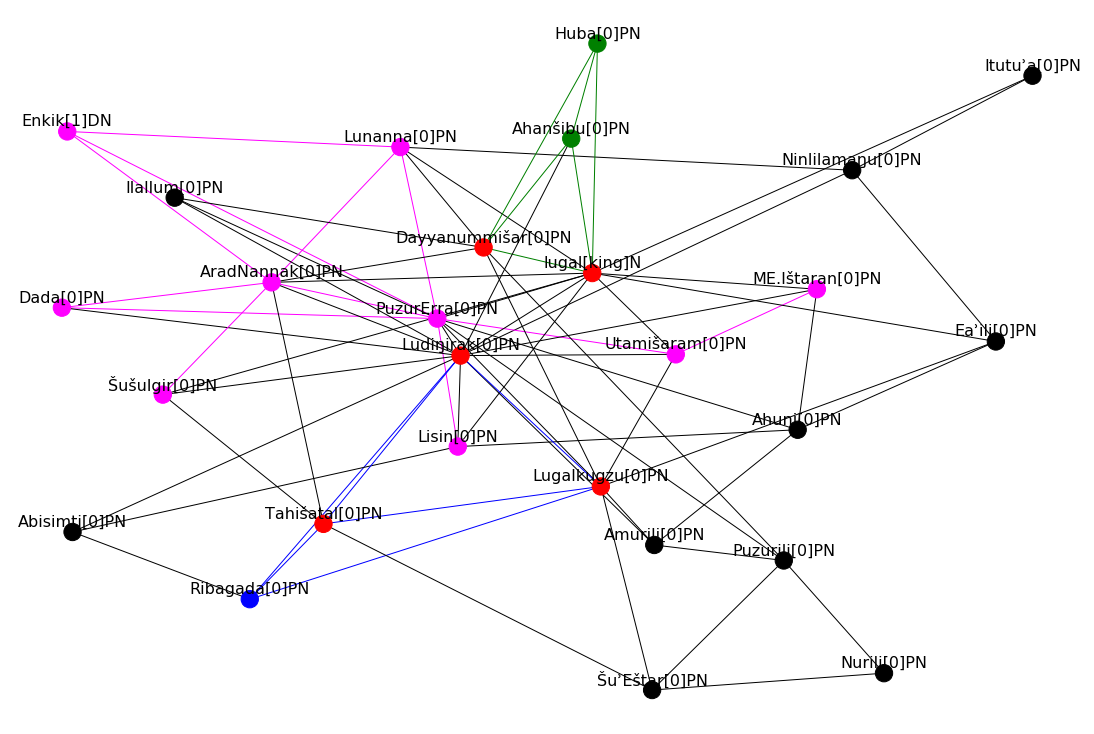

In [74]:
label_pos = {}
pos = nx.spring_layout(I)
for k, v in pos.items():
    label_pos[k] = (v[0], v[1]+0.03)
plt.figure(figsize=(15, 10))
#plt.rcParams.update({'figure.figsize': (15, 10)})
nx.draw(
        I,
        pos=pos,
        node_color=node_color,
        edge_color=edge_color, 
        #node_size = node_size, 
        with_labels = False,
        #label=labels,
        cmap = colmap
        #cmap= plt.cm.jet
        )
nx.draw_networkx_labels(I, label_pos, labels, font_size=16)
plt.show()

13


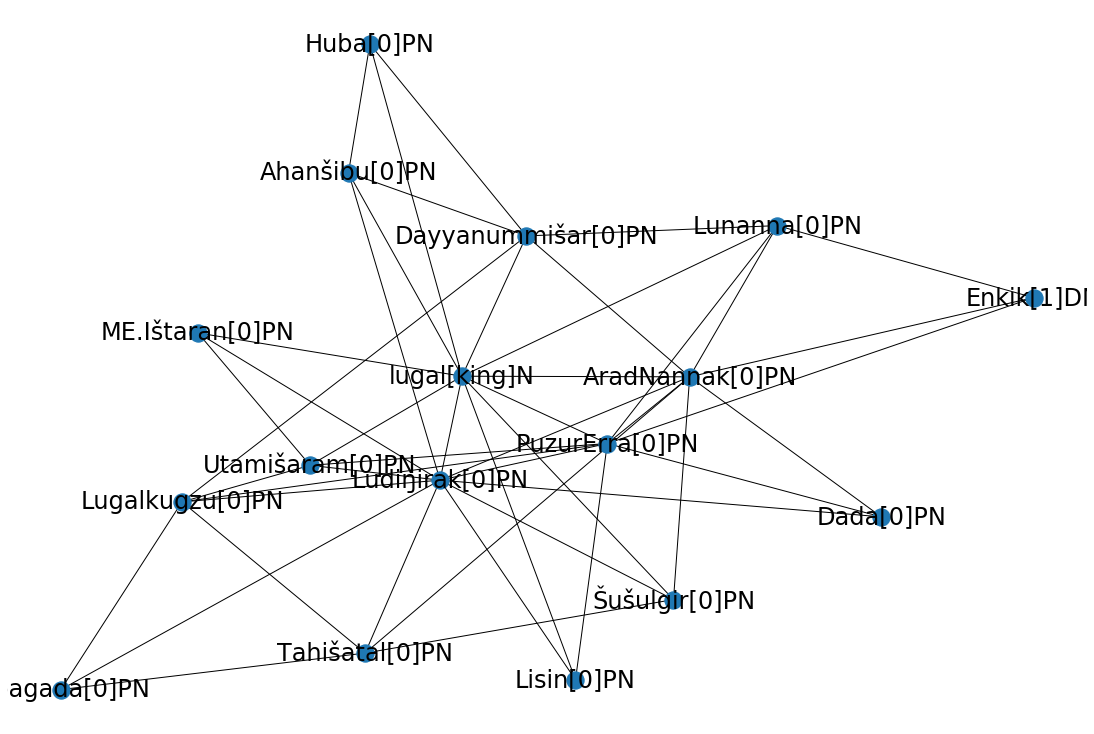

In [26]:
cliques = nx.find_cliques(H)
cliques4 = [clq for clq in cliques if len(clq) >= 4]
nodes = set(n for clq in cliques4 for n in clq)
print(len(cliques4))
h = H.subgraph(nodes)
nx.draw(h, with_labels=True, font_size = 24)
# from https://stackoverflow.com/questions/25222322/networkx-create-new-graph-of-all-nodes-that-are-a-part-of-4-node-clique

# Import Bokeh
The networkx module has facilities for displaying a network, but the options are limited. The Bokeh module has a much wider range of possibilities for drawing, inspecting, and exporting a network graph. The `from_networkx` function in Bokeh allows efficient import of nodes and edges.

In [ ]:
from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button
output_notebook()

# Tooltips for Nodes
This graph provides tooltips for each node, containing the name and the degree. By computing other characteristics of the node, one may easily display other attributes in the tooltip. 

The edges are not displayed by default, but light up when the mouse hovers over a node.

In [ ]:
plot = Plot(plot_width=900, plot_height=900,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Treasure Archive Drehem"

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size='node_size', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color=Spectral4[1], line_alpha=0.8, line_width=3)
plot.renderers.append(graph_renderer)

#output_file("interactive_graphs.html")
# when using output_file() bokeh will open a new tab
# when using output_file() continue with reset_output()
show(plot)

In [ ]:
plot = figure(plot_width=700, plot_height=700,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ("degree", "@degree")])
plot.add_tools(node_hover_tool)
plot.title.text = "Drehem Treasure Archive: the Nodes"

r = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

r.node_renderer.glyph = Circle(size='node_size', fill_color='#2b83ba')
r.node_renderer.hover_glyph = Circle(size='node_size', fill_color='#abdda4')

r.edge_renderer.glyph = MultiLine(line_alpha=0, line_width='weight')  # zero line alpha
r.edge_renderer.hover_glyph = MultiLine(line_color='#abdda4', line_width=5)

r.inspection_policy = NodesAndLinkedEdges()
plot.renderers.append(r)

show(plot)

In [ ]:
plot = Plot(plot_width=1000, plot_height=900,
            x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
plot.title.text = "Drehem Treasure Archive"

graph_renderer = from_networkx(G, nx.circular_layout, scale=1.9, center=(0, 0))
#graph_renderer.edge_renderer.data_source.data["line_width"] = [G.get_edge_data(a,b)['weight'] for a, b in G.edges()]
#graph_renderer.edge_renderer.glyph.line_width = {'field': 'line_width'}
graph_renderer.edge_renderer.glyph.line_alpha = 0.8
graph_renderer.node_renderer.selection_glyph = Circle(size='degree', fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size='degree', fill_color=Spectral4[1])
graph_renderer.node_renderer.glyph = Circle(size='degree', fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width = 'weight')
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width = 'weight')
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width =  'weight')

graph_renderer.inspection_policy = NodesAndLinkedEdges()
graph_renderer.selection_policy = EdgesAndLinkedNodes()

node_hover_tool = HoverTool(tooltips=[("name", "@name"), ('degree', '@value')])
plot.renderers.append(graph_renderer)
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
# output_file("vis/interactive_graphs.html")
show(plot)

# Tooltips for Edges
The following code draws a network of the Drehem Treasure Archive. By selecting a node (click on the node) the node and all its direct neighbors are highlighted and the button below the drawing links to the collection of texts in ORACC from which these edges come.
# TODO
The list of P numbers is currently not unique - a P number may provide more than one relevant edge.

In [ ]:
plot = Plot(plot_width = 900, plot_height = 900,
            x_range = Range1d(-1.1, 1.1), y_range = Range1d(-1.1, 1.1))
plot.title.text = "Drehem Treasure Archive"

plot.add_tools(HoverTool(tooltips = [('Text ID', '@id_text'), ('start', '@start'), ('end', '@end')]), 
               TapTool(), BoxSelectTool(), ResetTool(), BoxZoomTool(), SaveTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale = 1, center = (0, 0))

graph_renderer.node_renderer.glyph = Circle(size = 'node_size', fill_color = Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size = 'node_size', fill_color = Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size = 'node_size', fill_color = Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color = "#CCCCCC", line_alpha = 0.8, line_width = 5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color = Spectral4[2], line_width = 5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color = Spectral4[1], line_width = 5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

info_text_ids = TextInput(title = 'Text IDs:', value = '')
info_start_end = TextInput(title = 'Start => End Values:', value = '')
url = "http://oracc.org/epsd2/admin/ur3/"
esource = graph_renderer.edge_renderer.data_source
code = """  start_end_values = []
            text_ids = []
            for(idx in esource.selected.indices)
            {
                index = esource.selected.indices[idx]
                start_end_values.push(esource.data['start'][index] + '=>' + esource.data['end'][index] ); 
                text_ids.push(esource.data['id_text'][index]) 
            }
            info_start_end.value = String(start_end_values);
            info_text_ids.value = String(text_ids);"""
code2 = """ urlnew = url.concat(info_text_ids.value);
            window.open(urlnew)"""
callback = CustomJS(args = dict(esource = esource, 
                                info_text_ids = info_text_ids, 
                                info_start_end = info_start_end), 
                    code = code)
plot.select_one(TapTool).callback = callback
button = Button(label="Click to open text editions", button_type="success")
button.js_on_click(CustomJS(args = dict(url=url, info_text_ids=info_text_ids), 
                        code=code2))
show(Column(plot, info_start_end, info_text_ids, button))